In [7]:
!nvidia-smi

Sun May 28 19:09:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
import os
import pandas as pd

In [10]:
path = '/content/drive/MyDrive/data/programmers_ai/yujatea/comp_3/dataset/'

In [11]:
train_df = pd.read_csv(os.path.join(path, 'my_train.csv'))
test_df = pd.read_csv(os.path.join(path, 'my_test.csv'))

In [12]:
train_df.head()

,filename,width,height,x,y,w,h,label
0,0001.jpg,640,423,20.0,75.0,521.0,298.0,1
1,0002.jpg,1992,1328,231.9,249.4,1691.6,893.7,3
2,0003.jpg,600,440,87.0,68.0,417.0,319.0,2
3,0004.jpg,1600,1065,382.5,141.0,1107.5,836.2,2
4,0005.jpg,800,450,62.5,133.2,491.9,314.4,3


In [15]:
!git clone https://github.com/facebookresearch/detr.git   #cloning github repo of detr to import its unique loss

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (263/263), 12.88 MiB | 6.67 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [16]:
!pip install albumentations==0.4.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.1/116.1 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.4/631.4 kB 62.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.5-py3-none-any.whl size=64372 sha256=f2784b3a97ffe3964493cccf73f8d7581c411b6becce56fa8bba2f995cc48bd0
  Stored in directory: /root/.cache/pip/wheels/be/0c/f1/be15b7c7025416665227294d983a5405c8fde17427c0abb05d
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654003 sha256=6346f1f4bf9d850cd92501090d1f6491624d582e0026f77d3432344dd9d2c46d
  Stored in directory: /root/.cache/pip/wheels/cb/c7/a6/2d7a113c4885dc0f4eacd8f41095763181c0b9a18223ac7533
Successfully built albumentations imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.4.0
    Unin

In [17]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

<ipython-input-17-d875a0c87f69>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [85]:
n_folds = 5
seed = 42
num_classes = 5
num_queries = 100 # EDA 해서 max_bb 찾기
null_class_coef = 0.5
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 50

In [20]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [21]:
seed_everything(seed)

In [22]:
# Creating Folds
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

df_folds = train_df[['filename']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('filename').count()
df_folds.loc[:, 'label'] = train_df[['filename', 'label']].groupby('filename').min()['label']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['label'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [23]:
# https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9), # RGB 임의로 shuffling
                               
                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),
                      
                      A.ToGray(p=0.01),
                      
                      A.HorizontalFlip(p=0.5),
                      
                      A.VerticalFlip(p=0.5),
                      # https://leedakyeong.tistory.com/entry/Python-albumentations-%EB%9D%BC%EC%9D%B4%EB%B8%8C%EB%9F%AC%EB%A6%AC%EB%A5%BC-%EC%9D%B4%EC%9A%A9%ED%95%9C-Image-Agumentation,
                      A.LongestMaxSize (max_size=512),
                      A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT), 
                       
                      
                      A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5), # 사진의 일부를 지우고 0으로 채움
                      
                      ToTensorV2(p=1.0)],
                      
                      p=1.0,
                     
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels']) # 바운딩 박스 표기법 yolo
                      )

def get_valid_transforms():
    return A.Compose([ A.LongestMaxSize (max_size=512),
                       A.PadIfNeeded(512, 512, border_mode=cv2.BORDER_CONSTANT),
                       ToTensorV2(p=1.0)], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

In [84]:
DIR_TRAIN = '/content/drive/MyDrive/data/programmers_ai/yujatea/comp_3/dataset/train'

class CustomDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]
    
    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['filename'] == image_id]
        
        image = cv2.imread(f'{DIR_TRAIN}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = records[['x', 'y', 'w', 'h']].values
        
        #Area of bb
        area = boxes[:,2]*boxes[:,3] # w * h
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # AS pointed out by PRVI It works better if the main class is labelled as zero(???)
        labels =  np.zeros(self.df[self.df['filename'] == image_id]['label'].values, dtype=np.int32)

        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
            
            
        #Normalizing BBOXES
            
        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        
        return image, target, image_id

In [25]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True) # pretrained된 DETR 모델
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,images):
        return self.model(images)

In [26]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

In [86]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    summary_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
        
    return summary_loss

In [27]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    
    return summary_loss

In [28]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [30]:
def run(fold):
    
    df_train = df_folds[df_folds['fold'] != fold]
    df_valid = df_folds[df_folds['fold'] == fold]
    
    train_dataset = CustomDataset(
    image_ids=df_train.index.values,
    dataframe=train_df,
    transforms=get_train_transforms()
    )

    valid_dataset = CustomDataset(
    image_ids=df_valid.index.values,
    dataframe=train_df,
    transforms=get_valid_transforms()
    )
    
    train_data_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
    )
    
    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes,num_queries=num_queries)
    model = model.to(device)
    criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
    criterion = criterion.to(device)
    

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    
    best_loss = 10**5
    for epoch in range(EPOCHS):
        train_loss = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_loss = eval_fn(valid_data_loader, model,criterion, device)
        
        print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
            torch.save(model.state_dict(), f'/content/drive/MyDrive/data/programmers_ai/yujatea/comp_3/detr_best_{fold}.pth')

In [ ]:
run(fold=0)

In [45]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.load_state_dict(torch.load("/content/drive/MyDrive/data/programmers_ai/yujatea/comp_3/detr_best_0.pth"))

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

[{'boxes': tensor([[0.5483, 0.4208, 0.2633, 0.3547],
        [0.1017, 0.2842, 0.4150, 0.4945]], device='cuda:0'), 'labels': tensor([0, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0'), 'area': tensor([33654., 73953.], device='cuda:0')}, {'boxes': tensor([[0.1055, 0.4934, 0.1086, 0.1064],
        [0.5922, 0.3653, 0.3195, 0.3300]], device='cuda:0'), 'labels': tensor([0, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0'), 'area': tensor([ 4732.9502, 43190.3984], device='cuda:0')}, {'boxes': tensor([[0.2239, 0.2703, 0.4908, 0.7297]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'image_id': tensor([2], device='cuda:0'), 'area': tensor([146638.], device='cuda:0')}, {'boxes': tensor([[0.3047, 0.3208, 0.3539, 0.3942]], device='cuda:0'), 'labels': tensor([0], device='cuda:0'), 'image_id': tensor([3], device='cuda:0'), 'area': tensor([268254.4375], device='cuda:0')}, {'boxes': tensor([[0.2141, 0.3148, 0.5039, 0.4087]], device='cuda:0'), 'labels': tensor([0]

100
(100, 5)
(100,)
0.99204105


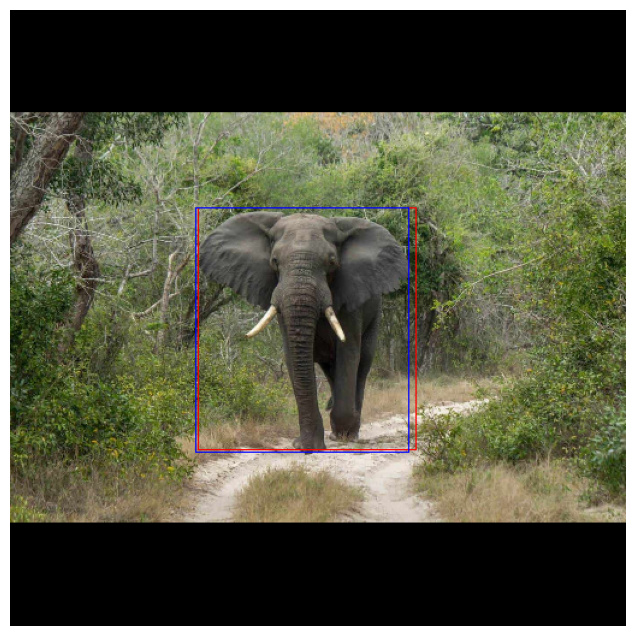

In [83]:
def view_sample(df_valid,model,device):
    '''
    Code taken from Peter's Kernel 
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    valid_dataset = CustomDataset(image_ids=df_valid.index.values,
                                 dataframe=train_df,
                                 transforms=get_valid_transforms()
                                )
     
    valid_data_loader = DataLoader(
                                    valid_dataset,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                   num_workers=4,
                                   collate_fn=collate_fn)
    
    images, targets, image_ids = next(iter(valid_data_loader))
    
    _,h,w = images[0].shape # for de normalizing images
    
    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    print(targets)
    rand_idx = np.random.randint(0, 8, 1)[0]
    print(rand_idx)
    boxes = targets[rand_idx]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    sample = images[rand_idx].permute(1,2,0).cpu().numpy()
    
    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")
    
    with torch.no_grad():
        outputs = model(images)
        
    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]
    print(len(outputs[0]['pred_logits'][rand_idx]))
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)

    label_dict = {0: 'Buffalo', 1: 'Elephant', 2: 'Rhinoceros',3: 'Zebra'}

    oboxes = outputs[0]['pred_boxes'][rand_idx].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    print(outputs[0]['pred_logits'][rand_idx].softmax(1).detach().cpu().numpy().shape)
    prob   = outputs[0]['pred_logits'][rand_idx].softmax(1).detach().cpu().numpy()[:,0]
    print(prob.shape)
    for box,p in zip(oboxes, prob):
        if p > 0.75:
            print(p)
            color = (0,0,220) #if p>0.5 else (0,0,0)
            cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  color, 1)
    
    ax.set_axis_off()
    ax.imshow(sample)


view_sample(df_folds[df_folds['fold'] == 0],model=model,device=torch.device('cuda'))